In [5]:
%load_ext autoreload
%autoreload 2

import sys    
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "7"

import pickle
import warnings
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
from IPython.display import clear_output
from sklearn.utils import shuffle
from torch import LongTensor
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm

warnings.filterwarnings("ignore", category=DeprecationWarning) 
    
from constants import ARTIFACTS_DIR, PROJECT_DIR

from ibmd.core import IBMD
from pfgmpp.core import PFGMPP
from pfgmpp.training.losses import EDMLoss
from pfgmpp.utils.data import InfiniteDataLoader

sys.path.append(f"{PROJECT_DIR}/src/pfgmpp_original")

ckpt_name = "cifar10_ncsnpp_D_2048_conditional.pkl"
EDM_CHEKPOINT_PATH = os.path.join(ARTIFACTS_DIR, "pfgmpp_original", "checkpoints", ckpt_name)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
# Utils

In [10]:
# Poblem Params (CIFAR-10)
IMG_CHANNELS =  3
IMG_RESOLUTION = 32
DATA_DIM = IMG_CHANNELS * IMG_RESOLUTION**2
N_CLASSES = 10

SIGMA_MIN = 0.002
SIGMA_MAX = 80.0
POWER = 11

# Loss Params
SIGMA_PRIOR_MODE = "log_normal"
SIGMA_DATA = 0.5 

# Sampling params
N_GENS = 1
LABELS = torch.tensor([0] * N_GENS).long()

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [14]:
def generate(
    *,
    pfgmpp: PFGMPP,
    net: nn.Module,
    sample_size: int,
    num_steps: int=32,
    label: LongTensor=None,
    seed: int=0,
):
    def drift(*, x, t, label):
        return (x - net(x=x, t=t, label=label)) / t
    return pfgmpp.sample(
        drift=drift,
        sample_size=sample_size,
        num_steps=num_steps,
        label=label,
        device=DEVICE,
        seed=seed,
    ).cpu().numpy().reshape(sample_size, IMG_CHANNELS, IMG_RESOLUTION, IMG_RESOLUTION)

In [31]:
# PFGM teacher init

In [32]:
pfgmpp = PFGMPP(
    data_dim=DATA_DIM,
    sigma_min=SIGMA_MIN,
    sigma_max=SIGMA_MAX,
    D=2**POWER,
)
with open(EDM_CHEKPOINT_PATH, "rb") as f:
    net = pickle.load(f)['ema'].to(DEVICE);
pfgmpp_cond = lambda x, t, label: net(
    x=x.reshape(-1, IMG_CHANNELS, IMG_RESOLUTION, IMG_RESOLUTION),
    sigma=t,
    class_labels=F.one_hot(label, num_classes=N_CLASSES),
).reshape(-1, DATA_DIM)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.85427904..1.0783778].


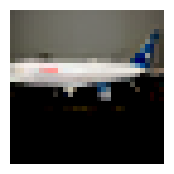

In [34]:
gens = generate(pfgmpp=pfgmpp, net=pfgmpp_cond, sample_size=N_GENS, label=LABELS.to(DEVICE), seed=0)
plt.figure(figsize=(2, 2))
plt.axis("off")
plt.imshow(gens[0].transpose(1, 2, 0));

In [ ]:
# IBMD init

In [35]:
BATCH_SIZE = 32
INNER_PROBLEM_ITERS = 5

In [36]:
ibmd = IBMD(
    teacher_dynamic=pfgmpp,
    teacher_net=pfgmpp_cond,
    teacher_loss_fn=EDMLoss(pfgmpp=pfgmpp),
    student_net_optimizer_config={"lr": 5e-5},
    student_data_estimator_net_config={"lr": 5e-5},
    n_classes=N_CLASSES,
    ema_decay=0.99,
)

AttributeError: 'function' object has no attribute 'parameters'